In [1]:
### compositionevo.ipynb
### Script to extract composition correlation evolution

import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
from importlib import reload
import numpy as npy
from matplotlib import rc
import matplotlib.colors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import pkdgrav_ss as pkd
import os
import copy
import math
from scipy import optimize
import ipywidgets as widgets
from IPython.display import display
import time

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

mearth = 1./330060.

maxnumf = 6000 #6000  #500,160 #40,200,2000   # max number of output steps
nsim = 21  # number of similar planetesimals to extract

##g = 1  # number of giant planets
##getcore = True  # load core data?


# set limits for full color scale
#colbins = 25
#mincol = 0.5
#maxcol = 3.0


#path = '../../cfGTruns/'#'data/'
path = '../../../LocalData/'#'data/'
loc = path + '022GTJf6hydrogas_2/' #'022GTJf6hydrogas/' #'022GTJf6hgas/' #'/cfGTruns/022GTJf6hydrogas/'

##loc_c = path + '022f6simpgas_4/' #'022f6sgas_4/'
#loc = path + '022f6simpgas_4/' #'022f6sgas_4/'

emb = [0,1,2,3,4,5,6,7,8]  # embryo number to extract

##collmod = True
##rho = 2.  # planetesimal density (for size scale)#
##expfac = 6.  # expansion factor

#cccut = 0.95  # correlation limit for very similar (combined fragment plot)


In [2]:
# create output file list
stepfac = 1.
param = pkd.readparam(loc+'ss.par')
ndig = param['nDigits']
mstep = int(param['iOutInterval'])

k = 1
while int(param['nSteps']/param['iOutInterval']/k)>maxnumf:
    k += 1 # *=2
mstep *= int(k)

files = npy.arange(0,param['nSteps'] + mstep,stepfac*mstep).astype(int)#/param['iOutInterval']).astype(int) * int(param['iOutInterval'])
if files[-1]>param['nSteps']:
    files = files[0:-1]
if files[-1] != int(param['nSteps']):
    files = npy.append(files,int(param['nSteps']))

#files = npy.arange(5*int(param['iOutInterval']),int(param['nSteps'])+5*int(param['iOutInterval']),5*int(param['iOutInterval']))
print(files,len(files))

amin = param['dDustBinsInner']
amax = param['dDustBinsOuter']
nbins = int(param['nDustBins'])
binedge = npy.linspace(amin,amax,nbins+1)

print(binedge)

[        0     20000     40000 ... 119960000 119980000 120000000] 6001
[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]


In [3]:
#reload(pkd)
col = 0
col = pkd.collisions(path=loc)

ss = pkd.ss()
ss.read(loc+'ss.{:0>10d}'.format(int(param['nSteps'])),extras=True)
ss.calcOE()
sorder = npy.argsort(ss.m)[::-1]
ind = npy.arange(len(ss.a))[(ss.a[sorder]<3.5)*(ss.e[sorder]<1.)]
indlen = len(ind)

sorder = npy.argsort(ss.m)[::-1]
id1 = ss.id[sorder]
ob = ss.origin[sorder]

for j in emb:
    emb = id1[ind[j]]  # pkdgrav embryo id
    print('embryo id: ',emb)
    obbig = ob[ind[j]]

    time=npy.array([])

    cct=npy.array([])
    #cct1 = npy.array([])
    #cct2 = npy.array([])
    #cct3 = npy.array([])
    #cct4 = npy.array([])
    #cct5 = npy.array([])
    #cct6 = npy.array([])
    #cct7 = npy.array([])
    #cct8 = npy.array([])
    cclist = [] #[cct,cct1,cct2,cct3,cct4,cct5,cct6,cct7,cct8]

    for l in range(nsim):
        cclist.append(cct.copy())

    mt = npy.array([])
    #mt1 = npy.array([])
    #mt2 = npy.array([])
    #mt3 = npy.array([])
    #mt4 = npy.array([])
    #mt5 = npy.array([])
    #mt6 = npy.array([])
    #mt7 = npy.array([])
    #mt8 = npy.array([])
    mlist = [] #[mt,mt1,mt2,mt3,mt4,mt5,mt6,mt7,mt8]

    for l in range(nsim):
        mlist.append(mt.copy())

    at = npy.array([])
    alist = [] #[mt,mt1,mt2,mt3,mt4,mt5,mt6,mt7,mt8]

    for l in range(nsim):
        alist.append(at.copy())


    #for fn in files:
    #    if fn == 0:
    #        continue
    #    sst = pkd.ss()
    #    sst.read(loc+'ss.{:>010d}'.format(fn),extras=True)
    #    time = npy.append(time,sst.header.t)
    #    #print(fn,sst.header.t,sst.m[sst.id==emb][0])
    #    res = npy.corrcoef(obbig,sst.origin[sst.id==emb])
    #    print(res, len(sst.id[sst.id==emb]))
    #    cct = npy.append(cct,res[0,1])
    #    mt = npy.append(mt,sst.m[sst.id==emb][0])
    #    for k in range(1,9):
    #      if len(sst.id[sst.id==id1[ind[corder[k]]]])>0:
    #        res = npy.corrcoef(obbig,sst.origin[sst.id==id1[ind[corder[k]]]])
    #        #print id1[ind[corder[k]]],res,len(sst.id[sst.id==id1[ind[corder[k]]]])
    #        cclist[k] = npy.append(cclist[k],res[0,1])
    #        mlist[k] = npy.append(mlist[k],sst.m[sst.id==id1[ind[corder[k]]]][0])
    #      else:
    #        cclist[k] = npy.append(cclist[k],-99)
    #        mlist[k] = npy.append(mlist[k],1e-12)


    trackIDk = npy.zeros(nsim)
    newtrackIDk = npy.zeros(nsim)
    changetk = npy.zeros(nsim)
    changet = 0.
    c0=npy.array([]) #=c1=c2=c3=c4=c5=c6=c7=c8=
    ck = [] #[c0,c1,c2,c3,c4,c5,c6,c7,c8]

    for l in range(nsim):
        ck.append(c0.copy())

    trackID = id1[ind[j]]
    c = npy.sort(col.get_history(trackID))

    print(c,npy.sort(c))

    print(col.t[c])


    resarr = npy.zeros(indlen)

    for i in range(0,indlen,1):
      res = npy.corrcoef(obbig,ob[ind[i]])
      resarr[i]=res[0,1]
    corder=npy.argsort(resarr)[::-1]


    # find final 'historical' ids of this embryo

    for ic in c[::-1]:
            if col.idlr[ic]==trackID:
                if col.idt[ic]!=trackID:
                    newtrackID = col.idt[ic]
                    changet = col.t[ic]
                    break
            elif col.idslr[ic] == trackID:
                if col.idp[ic]!=trackID:
                    newtrackID = col.idp[ic]
                    changet = col.t[ic]
                    break

    print('change:',changet,trackID,newtrackID,col.type[ic],col.idlr[ic],col.mlr[ic],col.idt[ic],col.mt[ic],col.idp[ic],col.idslr[ic],col.mslr[ic])

    # and similar planetesimals
    for k in range(1,nsim):
        trackIDk[k] = id1[ind[corder[k]]]
        ck[k] = npy.sort(col.get_history(trackIDk[k]))
        for ic in ck[k][::-1]:
            if col.idlr[ic]==trackIDk[k]:
                if col.idt[ic]!=trackIDk[k]:
                    newtrackIDk[k] = col.idt[ic]
                    changetk[k] = col.t[ic]
                    break
            elif col.idslr[ic]==trackIDk[k]:
                if col.idp[ic]!=trackIDk[k]:
                    newtrackIDk[k] = col.idp[ic]
                    changetk[k] = col.t[ic]
                    break


    # calculate correlations with embryo through time

    fout = open(loc+'comp_evolution-{:d}.dat'.format(j),'w')

    for fn in files[::-1]:
        sst = pkd.ss()
        if fn == 0:
            sst.read(loc+'ssic.ss')
            sst.id = sst.org_idx
            sst.origin = npy.array([npy.histogram(x,binedge)[0] for x in npy.sqrt(sst.x**2+sst.y**2)])
            #sst.origin = npy.array([npy.histogram(x,binedge[0:11])[0] for x in npy.sqrt(sst.x**2+sst.y**2)])
        else:
            sst.read(loc+'ss.{:>010d}'.format(fn),extras=True)
        sst.calcOE()
        time = npy.append(time,sst.header.t)

        while sst.header.t/2./math.pi < changet and newtrackID != trackID:
            trackID=newtrackID
            for ic in c[::-1][npy.argwhere((col.idlr[c[::-1]]==trackID)+(col.idslr[c[::-1]]==trackID))]:
                if col.idlr[ic]==trackID:
                    #if trackID== 58081 or trackID == 57006:
                    #    print(col.type[ic],col.t[ic],col.idlr[ic],col.mlr[ic],col.idt[ic],col.mt[ic])
                    if col.idt[ic]!=trackID and col.t[ic] < changet:
                        newtrackID = col.idt[ic]
                        changet = col.t[ic]
                        print('change:',changet,trackID,newtrackID,col.type[ic],col.idlr[ic],col.mlr[ic],col.idt[ic],col.mt[ic],col.idp[ic],col.idslr[ic],col.mslr[ic])
                        break
                elif col.idslr[ic]==trackID:
                    if col.idp[ic]!=trackID and col.t[ic] < changet:
                        newtrackID = col.idp[ic]
                        changet = col.t[ic]
                        print('change:',changet,trackID,newtrackID,col.type[ic],col.idlr[ic],col.mlr[ic],col.idt[ic],col.mt[ic],col.idp[ic],col.idslr[ic],col.mslr[ic])
                        break

        #print('trackID:',trackID)                
        #print(fn,sst.header.t,sst.m[sst.id==emb][0])
        res = npy.corrcoef(obbig,sst.origin[sst.id==trackID])
        #print res, len(sst.id[sst.id==trackID])
        cct = npy.append(cct,res[0,1])
        mt = npy.append(mt,sst.m[sst.id==trackID][0])
        at = npy.append(at,sst.a[sst.id==trackID][0])

        #write time mt cct
        #fout.write( '{:.10g}'.format(sst.header.t) + ' {:.8g}'.format(sst.m[sst.id==trackID][0]) + ' {:.4f}'.format(res[0,1]) )
        fout.write( '{:.10g}'.format(sst.header.t) + ' {:.8g}'.format(sst.m[sst.id==trackID][0]) + ' {:.4f}'.format(sst.a[sst.id==trackID][0]) + ' {:.4f}'.format(res[0,1]) )

        for k in range(1,nsim):
          while sst.header.t/2./math.pi < changetk[k] and newtrackIDk[k] != trackIDk[k]:
            trackIDk[k]=newtrackIDk[k]
            #ck[k] = col.get_history(trackIDk[k])
            for ic in ck[k][::-1][npy.argwhere((col.idlr[ck[k][::-1]]==trackIDk[k])+(col.idslr[ck[k][::-1]]==trackIDk[k]))]:
                if col.idlr[ic]==trackIDk[k]:
                    if col.idt[ic]!=trackIDk[k] and col.t[ic] < changetk[k]:
                        newtrackIDk[k] = col.idt[ic]
                        changetk[k] = col.t[ic]
                        print('change-k:',k,changetk[k],trackIDk[k],newtrackIDk[k],col.type[ic],col.idlr[ic],col.mlr[ic],col.idt[ic],col.mt[ic],col.idp[ic],col.idslr[ic],col.mslr[ic])
                        if k==1:
                            print(changetk[k],newtrackIDk[k])
                        break
                elif col.idslr[ic]==trackIDk[k]:
                    if col.idp[ic]!=trackIDk[k] and col.t[ic] < changetk[k]:
                        newtrackIDk[k] = col.idp[ic]
                        changetk[k] = col.t[ic]
                        print('change-k:',k,changetk[k],trackIDk[k],newtrackIDk[k],col.type[ic],col.idlr[ic],col.mlr[ic],col.idt[ic],col.mt[ic],col.idp[ic],col.idslr[ic],col.mslr[ic])
                        if k==1:
                            print(changetk[k],newtrackIDk[k])
                        break

          if len(sst.id[sst.id==trackIDk[k]])>0:
            res = npy.corrcoef(obbig,sst.origin[sst.id==trackIDk[k]])
            #print id1[ind[corder[k]]],res,len(sst.id[sst.id==id1[ind[corder[k]]]])
            cclist[k] = npy.append(cclist[k],res[0,1])
            mlist[k] = npy.append(mlist[k],sst.m[sst.id==trackIDk[k]][0])
            alist[k] = npy.append(alist[k],sst.a[sst.id==trackIDk[k]][0])
            # write mk cck
            #fout.write( ' {:.8g}'.format(sst.m[sst.id==trackIDk[k]][0]) + ' {:.4f}'.format(res[0,1]) )
            fout.write( ' {:.8g}'.format(sst.m[sst.id==trackIDk[k]][0]) +  ' {:.4f}'.format(sst.a[sst.id==trackIDk[k]][0]) + ' {:.4f}'.format(res[0,1]) )
          else:
            cclist[k] = npy.append(cclist[k],-99)
            mlist[k] = npy.append(mlist[k],1e-25)
            alist[k] = npy.append(alist[k],-99)
            # write mk cck
            #fout.write( ' {:.8g}'.format(1.e-25) + ' {:.4f}'.format(-99.0) )
            fout.write( ' {:.8g}'.format(1.e-25) + ' {:.4f}'.format(-99.0) + ' {:.4f}'.format(-99.0) )
        fout.write('\n')
    fout.close()

    print('File: comp_evolution-{:d}.dat'.format(j),' written.\n')

embryo id:  3506
Found 108 collisions for object: 3506
[  0   1   2   4   7  11  12  13  17  18  19  22  25  26  28  30  32  34
  37  38  42  45  46  47  52  56  57  58  59  60  61  62  64  65  66  70
  72  73  74  76  77  82  85  88  91  94  95  96  97  99 100 101 102 104
 105 106 107 108 109 112 116 126 129 131 134 139 145 148 149 150 152 154
 155 165 168 169 173 177 182 196 198 213 220 222 223 225 226 228 230 235
 247 248 250 251 252 256 258 259 263 265 267 270 272 274 283 297 300 312] [  0   1   2   4   7  11  12  13  17  18  19  22  25  26  28  30  32  34
  37  38  42  45  46  47  52  56  57  58  59  60  61  62  64  65  66  70
  72  73  74  76  77  82  85  88  91  94  95  96  97  99 100 101 102 104
 105 106 107 108 109 112 116 126 129 131 134 139 145 148 149 150 152 154
 155 165 168 169 173 177 182 196 198 213 220 222 223 225 226 228 230 235
 247 248 250 251 252 256 258 259 263 265 267 270 272 274 283 297 300 312]
[295194.24214349 295807.22740681 296960.54370193 297861.81825029
 3

In [ ]:
print(sst.origin[sst.id[sst.id==99957][0]])
#print(changetk*36/2./math.pi/1e6)
#print(trackIDk,newtrackIDk)
#print(trackIDk[10])
print(c)
trackID=78714#97897
print(npy.sort(col.get_history(78714)))
for ic in npy.sort(c)[::-1]:#[npy.argwhere((col.idp[c[::-1]]==trackID)+(col.idt[c[::-1]]==trackID))]:
#for l in range(len(ck[10])):
    #ic=npy.sort(ck[10])[::-1][l]
    #print('ic:',ic)
    if col.idt[ic]==trackID:
        print(ic,col.idt[ic],col.idlr[ic],col.idslr[ic],36*col.t[ic]/1e6,col.mt[ic]*330060,col.mp[ic]*330060,col.mlr[ic]*330060,col.mslr[ic]*330060)
print(sst.m[sst.org_idx==trackIDk[10]]*330060)
print(36*sst.header.t/2./math.pi/1e6)
#print(time, mlist[10]*330060)
print(col.t.max())
#print(col.t[col.idt==trackIDk[10]])
print(binedge)

2402


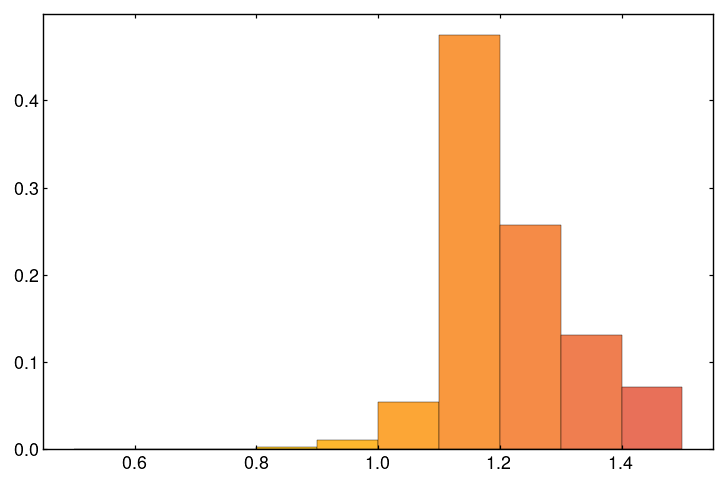

ValueError: shapes (2402,10) and (25,) not aligned: 10 (dim 1) != 25 (dim 0)

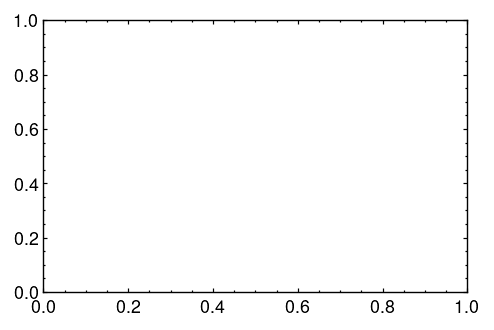

In [19]:
### DELETE THIS CELL
# scatter plot point size function
param = pkd.readparam(loc+'ss.par')

maxmass = 6e-6  # upper limit for mass size scale (solar masses)

smin = math.sqrt(5.)      #8., 1.1  #3.
smax = math.sqrt(300.)        #400.
if collmod:
    minrad = (3.*(param['dCollMinMass']*1.99e33)/(4.*math.pi*rho))**(1./3.)/1.5e13*expfac
else:
    minrad = (3.*(1e-12*1.99e33)/(4.*math.pi*rho))**(1./3.)/1.5e13*expfac
maxrad = (3.*(maxmass*1.99e33)/(4.*math.pi*rho))**(1./3.)/1.5e13*expfac

def marksize(m,mov=False):
    sizes = (smax-smin)*((3.*m*1.99e33/(4.*math.pi*rho))**(1./3.)/1.5e13*expfac-minrad)/(maxrad-minrad) + smin
    sizes = npy.where(sizes<smin,smin,sizes)
    if mov:
        sizes = npy.where(sizes>1.2*smax,1.25*smax,sizes)
        sizes = npy.where(m>100*maxmass,1.8*smax,sizes)
        sizes /= 2.
    else:
        sizes = npy.where(sizes>1.1*smax,1.2*smax,sizes)
        sizes = npy.where(m>100*maxmass,1.4*smax,sizes)
        sizes /= 1.5
    return sizes**2

#print(maxrad,minrad)

cmap = cm = copy.copy(plt.get_cmap('plasma_r'))
cm.set_over('slategrey') #'darkblue'
cm.set_under('k') #'k'

nbins = 25

ss = pkd.ss()
ss.read(loc+'ss.{:0>10d}'.format(int(param['nSteps'])),extras=True)
ss.calcOE()
sorder = npy.argsort(ss.m)[::-1]
#ind = sorder[(ss.a[sorder]<3.5)*(ss.e[sorder]<1.)]
aorder = npy.arange(len(ss.a))
ind = aorder[(ss.a[sorder]<3.5)*(ss.e[sorder]<1.)]
indlen = len(ind)

amin = param['dDustBinsInner']
amax = param['dDustBinsOuter']
binedge = npy.linspace(amin,amax,nbins+1)

bina = npy.linspace(0.55,2.95,nbins)

cnorm = norm = mpl.colors.Normalize(vmin=0.5, vmax=3.0)
cval = npy.linspace(0.5,3.0,25+1)[0:nbins]

print(indlen)

a1 = ss.a[sorder]
m1 = ss.m[sorder]
e1 = ss.e[sorder]
id1 = ss.id[sorder]
ob = ss.origin[sorder]


plt.bar(npy.arange(amin,amin+0.1*len(ob[ind[j]]),0.1),ob[ind[j]],width=0.1,color=cmap(norm(cval)),align='edge',edgecolor='k',lw=0.2)
plt.show()

obbig = ob[ind[j]]
resarr = npy.zeros(indlen)

for i in range(0,indlen,1):
  res = npy.corrcoef(obbig,ob[ind[i]])
  resarr[i]=res[0,1]
corder=npy.argsort(resarr)[::-1]

    
# correlation vs semi-major axis with color and size
plt.figure(figsize=(3.8,2.5))
plt.minorticks_on()
plt.scatter(a1[ind],resarr,s=marksize(m1[ind]),c=npy.dot(ob[ind],bina[0:nbins]),cmap=cm,norm=cnorm)
plt.scatter(a1[ind[j]],resarr[j],edgecolor='k',s=1.8*marksize(m1[ind[j]]),facecolor='none',lw=1.2)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Semi-major axis (au)')

plt.tight_layout(pad=0.4,w_pad=0.5,h_pad=1.0)
#plt.savefig(loc+'correlation-a-{:d}.eps'.format(j))
plt.savefig(loc+'correlation-a-{:d}.pdf'.format(j))
plt.savefig(loc+'correlation-a-{:d}.png'.format(j),dpi=600)
##plt.savefig('correlation-m1.pdf', format='pdf', dpi=1000,transparent=True)
plt.xlim(0,3.5)
plt.ylim(ymax=1.1)
plt.show()


#----- plot closest histograms

plt.figure(figsize=(7.2,5.))

print('i', 'index', 'a', 'e', 'm', 'particle id','correlation coeff')
  

for i in range(0,9,1):
  plt.subplot(3,3,i+1)
  plt.minorticks_on()
  plt.bar(npy.arange(amin,amin+0.1*len(ob[ind[i]]),0.1),ob[ind[corder[i]]],width=0.1,color=cmap(cnorm(cval)),align='edge',edgecolor='k',lw=0.2)
  print(i, ind[corder[i]], a1[ind[corder[i]]],e1[ind[corder[i]]],m1[ind[corder[i]]]*330060.,id1[ind[corder[i]]],resarr[corder[i]])
  if i == 0:
    plt.gca().set_facecolor('0.85')
  if i>5:
        plt.xlabel('Semi-major axis (au)')
  if i in (0,3,6):
      plt.ylabel('Mass Fraction')
  plt.title('{:.3g} M$_\oplus$'.format(m1[ind[corder[i]]]*330060))
  plt.xlim(0.5,3.0)

plt.tight_layout(pad=0.3,w_pad=0.4,h_pad=0.6)
#plt.savefig(loc+'histograms9-{:d}.svg'.format(j))

plt.show()
